In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

/home/tadenoud/.virtualenvs/ml/local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/home/tadenoud/.virtualenvs/ml/local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10138133619493078567
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3343187968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15672964407610278602
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

vae.save('vae.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 40us/step - loss: 189.9482 - val_loss: 172.6903
Epoch 2/50
60000/60000 [==============================] - 4s 59us/step - loss: 170.0191 - val_loss: 167.3262
Epoch 3/50
60000/60000 [==============================] - 4s 71us/step - loss: 166.6851 - val_loss: 164.8406
Epoch 4/50
60000/60000 [==============================] - 4s 68us/step - loss: 164.5682 - val_loss: 163.1408
Epoch 5/50
60000/60000 [==============================] - 4s 68us/step - loss: 163.0815 - val_loss: 162.5845
Epoch 6/50
60000/60000 [==============================] - 4s 72us/step - loss: 161.9951 - val_loss: 161.0664
Epoch 7/50
60000/60000 [==============================] - 4s 70us/step - loss: 161.0764 - val_loss: 160.6155
Epoch 8/50
60000/60000 [==============================] - 4s 68us/step - loss: 160.2497 - val_loss: 159.9979
Epoch 9/50
60000/60000 [==============================] - 4s 70us/step - loss:

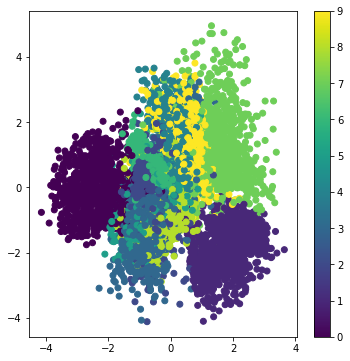

In [4]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

encoder.save('encoder.h5')

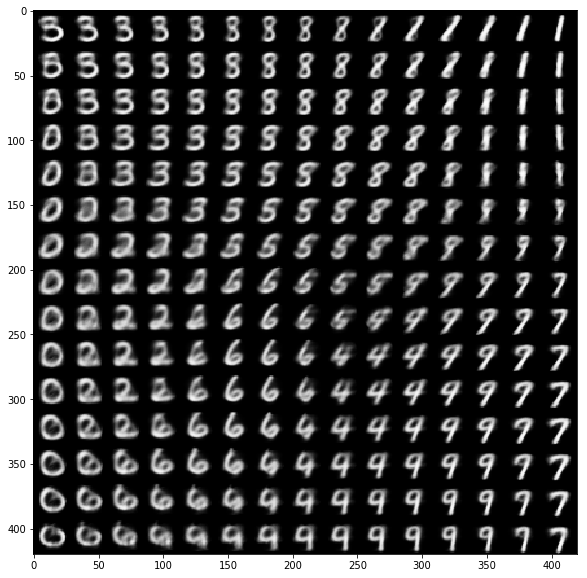

In [5]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

generator.save('generator.h5')

In [6]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(vae, './vaejs')
tfjs.converters.save_keras_model(encoder, './encoderjs')
tfjs.converters.save_keras_model(generator, './generatorjs')

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
grid_x = norm.ppf(np.linspace(0.05, 0.95, 15))
grid_y = norm.ppf(np.linspace(0.05, 0.95, 15))

In [3]:
print(grid_x)

[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
